## Import

In [ ]:
import os, gc, warnings, random, math
import datetime
from datetime import timedelta
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
!pip install tqdm
from tqdm import tqdm
import time
import copy
import pickle
import json

from time import sleep
from tqdm.contrib import tzip

warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
#from tensorflow.keras.optimizers import LambdaCallback
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

import torch
from torch.optim import Rprop

from random import seed

from tensorflow.keras import backend as K
from tensorflow.keras import initializers

from math import floor
from itertools import chain

import pandas as pd
import numpy as np
import operator
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler #менее подвержан выбросам
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
!pip install imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,matthews_corrcoef,recall_score,precision_score,classification_report,f1_score,cohen_kappa_score, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Настройки визуализации
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')
sns.set_context('talk')
%config InlineBackend.figure_format = 'svg'

## Определение функций

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues, norm=False, name = "default"):
    """
    Эта функция строит матрицу ошибок
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    if norm == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round_(cm, decimals=3)
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.grid(False)
    thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    plt.savefig(f'../svg/confusion_matrix_{name}_{thetime}.svg')
    plt.savefig(f'../png/confusion_matrix_{name}_{thetime}.png', dpi=300)
    plt.show()

def conf_matrix_bin (y_true, y_predict):
  TP = sum(np.array([(1 if (y_true[i]==1 and y_predict[i]==1) else 0) for i in range(len(y_true))]))
  FP = sum(np.array([(1 if (y_true[i]==0 and y_predict[i]==1) else 0) for i in range(len(y_true))]))
  FN = sum(np.array([(1 if (y_true[i]==1 and y_predict[i]==0) else 0) for i in range(len(y_true))]))
  TN = sum(np.array([(1 if (y_true[i]==0 and y_predict[i]==0) else 0) for i in range(len(y_true))]))
  return TP, FP, FN, TN


def accuracy_score(y_true, y_predict):
  TP, FP, FN, TN = conf_matrix_bin(y_true, y_predict)
  result = (TP+TN)/(TP+TN+FP+FN)
  return result

In [ ]:
###################################################################################
def max_min_scaler_norm_for_columns (df):
  """Нормализует столбцы dataframe"""
  columns = []
  columns = df.columns
  target_columns = []
  for i in columns:
    if (df[i].max() > 1)or(df[i].min() < 0):
      target_columns.append(i)
  for i in target_columns:
    df[i] = (df[i] - df[i].min())/(df[i].max()-df[i].min())

def max_min_scaler_norm_for_the_columns (df, columns):
  """Нормализует столбцы dataframe"""
  for i in columns:
    df[i] = (df[i] - df[i].min())/(df[i].max()-df[i].min())

def max_min_scaler_denorm_for_the_column (array_to_denorm, source_df, column):
  """Денормализует заданый столбец"""
  denormed_array = (array_to_denorm + source_df[column].min())*(source_df[column].max()-source_df[column].min())  
  return denormed_array
###################################################################################

In [ ]:
def dataframe_to_data_and_target_lists (df, long_of_list):
  """Построение data и target"""
  array_df = df.to_numpy()
  data = np.zeros((len(array_df)-long_of_list,long_of_list,len(df.columns)), dtype = float)
  target = np.zeros((len(array_df)-long_of_list, 1), dtype = float)
  for i in range(0, (len(array_df)-long_of_list)):
    for j in range(0, long_of_list):
      data[i][j] = array_df[i+j]
  for k in range(0, (len(array_df)-long_of_list)):
    target[k] = array_df[k+long_of_list][0]                       #Время должно быть в первом столбце
  return np.array(data, dtype = float), np.array(target, dtype = float)

## Основные параметры модуля

In [ ]:
DATA_PATH = '../data/'
PNG_PATH = '../png/'
PREPROCESSED_DATA_PATH = '../preprocessed data/'
LSTM_MODELS_PATH = '../lstm_models/'
LSTM_RESULTS_PATH = '../lstm_results/'
LSTM_HISTORY_PATH = '../lstm_histories/'

## Получение данных

In [ ]:
df_svista = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data.csv')
df_clusters = pd.read_csv(f'{PREPROCESSED_DATA_PATH}data_clusters.csv')

In [ ]:
df_svista

In [ ]:
df_clusters

## Модели для отдельных карт

#####Dictionary creating

In [ ]:
df_sv_card = {}
#Построение словаря содержащего транзакции по отдельным картам
for i in df_svista['CARDID_NUM'].unique():
  df_sv_card[i] = df_svista[df_svista['CARDID_NUM']==i]
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

In [ ]:
print("Количество признаков по каждой карте:")
for i in df_sv_card.keys():
  print(i,":", len(df_sv_card[i].columns))

In [ ]:
df_sv_card[2].columns

Index(['AMOUNT', 'AMOUNT_INST', 'DATE_TIME_SEC', 'TIME_DIFF', 'MCC_freq',
       'TERMINAL_ID_freq', 'AUTH_RESP_CODE_freq', 'MERCH_COUNTRY_freq',
       'MERCH_CITY_freq', 'MERCH_POSTAL_CODE_freq', 'MERCH_ID_freq',
       'CVV2_PRES_freq'],
      dtype='object')

##### Нормализация

In [ ]:
### Передвигаем столбцы в начало
for i in df_sv_card.keys():
  DATE_TIME_SEC_array = df_sv_card[i]['DATE_TIME_SEC']
  df_sv_card[i].drop(['DATE_TIME_SEC'], axis=1, inplace=True)
  df_sv_card[i].insert(0, 'DATE_TIME_SEC', DATE_TIME_SEC_array)

In [ ]:
df_sv_card[0]

In [ ]:
df_sv_card_normalized = {}
sv_scalers = {}
for i in df_sv_card.keys():
  df_sv_card_normalized[i] = df_sv_card[i].copy(deep=True)
  max_min_scaler_norm_for_columns(df_sv_card_normalized[i])

In [ ]:
df_sv_card_normalized[0]

#####Построение data & target

In [ ]:
df_sv_card_normalized_copy = {}
for i in df_sv_card_normalized.keys():
  df_sv_card_normalized_copy[i] = df_sv_card_normalized[i].copy(deep=True)

In [ ]:
df_sv_card_normalized[0]

In [ ]:
data_sv = {}
target_sv = {}
### Количество транзакций в одном ряду (предсказываем время long_of_list+1 исходя из long_of_list прошлых)
### Для тестов с различными параметрами модели
long_of_list = 10
for i in df_sv_card.keys():
  data_sv[i], target_sv[i] = dataframe_to_data_and_target_lists(df_sv_card_normalized[i], long_of_list)

###Обучение моделей

In [ ]:
data_sv_ns = {}
target_sv_ns = {}

x_train_d = {}
x_test_d = {}
y_train_d = {}
y_test_d = {}

In [ ]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.4.1
Default GPU Device: /device:GPU:0


In [ ]:
models = []
for i in tqdm(df_sv_card.keys()):
  x_train_d[i],x_test_d[i],y_train_d[i],y_test_d[i] = train_test_split(data_sv[i],target_sv[i],test_size=0.2, shuffle = False, random_state=4)
  seed(42)
  model = Sequential()
  model.add(CuDNNLSTM(3,batch_input_shape=(None, data_sv[i].shape[1],data_sv[i].shape[2]), return_sequences=True))
  model.add(CuDNNLSTM(3))
  model.add(Dense(1, activation='sigmoid'))
  models.append(model)

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:27<00:00,  6.89it/s]


In [ ]:
for model in models:
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['mae','accuracy'])

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
histories = [
    model.fit(
        x_train_d[i],y_train_d[i],epochs=2800,validation_data=(x_test_d[i],y_test_d[i]), verbose=0
        #callbacks=[callback], verbose=0
    ) for model, i in tzip(models, df_sv_card.keys())
]

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
model_results = []
for model, i in tzip(models, df_sv_card.keys()):
  result = model.predict(x_test_d[i])
  model_results.append(result)

In [ ]:
for history in histories:
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  print(hist.tail())

          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
2795  0.000088  0.005798       0.0  0.000471  0.018927      0.015873   2795
2796  0.000083  0.005823       0.0  0.000492  0.019609      0.015873   2796
2797  0.000082  0.005589       0.0  0.000477  0.019067      0.015873   2797
2798  0.000079  0.005269       0.0  0.000469  0.018921      0.015873   2798
2799  0.000080  0.005407       0.0  0.000481  0.019243      0.015873   2799
          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
2795  0.000154  0.006756       0.0  0.003279  0.053098      0.016129   2795
2796  0.000151  0.007165       0.0  0.003453  0.054446      0.016129   2796
2797  0.000149  0.006796       0.0  0.003304  0.053258      0.016129   2797
2798  0.000149  0.006482       0.0  0.003165  0.052281      0.016129   2798
2799  0.000165  0.007779       0.0  0.003543  0.055268      0.016129   2799
          loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
2795  0.0001

### Сохранение результатов обучения

In [ ]:
for model, i in tzip(models, df_sv_card.keys()):
  model.save(f'{LSTM_MODELS_PATH}my_model_for_{i}_card.h5')

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
for (history, i) in tzip(histories, df_sv_card.keys()):
  history_df = pd.DataFrame(history.history)
  history_df['epoch'] = history.epoch
  #json.dump(history_dict, open(f'{LSTM_HISTORY_PATH}', 'w'))
  with open(f'{LSTM_HISTORY_PATH}history_for_{i}_card.csv', mode='w') as f:
    history_df.to_csv(f, index=False)

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
# Save prediction
with open(f"{LSTM_RESULTS_PATH}model_results.txt", "wb") as fp:
  pickle.dump(model_results, fp)

### Загрузка

In [ ]:
with open(f"{LSTM_RESULTS_PATH}model_results.txt", "rb") as fp:
  model_results_save = pickle.load(fp)

In [ ]:
model_results_save[0][0]

In [ ]:
histories_dict = {}
for i in tqdm(df_sv_card.keys()):
  histories_dict[i] = pd.read_csv(f'{LSTM_HISTORY_PATH}history_for_{i}_card.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:05<00:00, 33.20it/s]


In [ ]:
histories_dict[0]

In [ ]:
models_dict = {}
for i in tqdm(df_sv_card.keys()):
  models_dict[i] = load_model(f'{LSTM_MODELS_PATH}my_model_for_{i}_card.h5')

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [01:59<00:00,  1.56it/s]


In [ ]:
model_results_save[0]

(63, 10, 1)

In [ ]:

# Проверка модели
model_results_load = []
j=0
for i in tqdm(df_sv_card.keys()):
  result = models_dict[i].predict(x_test_d[i])
  model_results_load.append(result);
for i in tqdm(df_sv_card.keys()): 
  if all(model_results_load[i] == model_results_save[i]):
    pass
  else:
    j=j+1
    print('\n',f'False {i}')
    break
if j==0:
  print('\n','True')



### Визуализация

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for card_number in df_sv_card.keys():
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['loss'], 'r', label='Training loss')
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['val_loss'], 'b', label='Validation loss')
  plt.title(f'Номер карты {card_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/loss_cards.png'):
  plt.savefig(f'{PNG_PATH}/loss_cards', dpi=100)
plt.show()

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for card_number in df_sv_card.keys():
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['mae'], 'r', label='Training loss')
  plt.plot(histories_dict[card_number]['epoch'], histories_dict[card_number]['val_mae'], 'b', label='Validation loss')
  plt.title(f'Номер карты {card_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/mae_cards.png'):
  plt.savefig(f'{PNG_PATH}/mae_cards', dpi=100)
plt.show()

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card.keys())/3))) #Размер поля

j=1
for (result, i) in zip(model_results_save, df_sv_card.keys()):
  plt.subplot(math.ceil(len(df_sv_card.keys())/3), 3, j)
  plt.scatter(range(y_test_d[i].shape[0]),np.array(result,dtype=float),c='r', label = 'Predition')
  plt.scatter(range(y_test_d[i].shape[0]),np.array(y_test_d[i],dtype=float),c='g', label = 'Actual')
  plt.title(f'Номер карты {i}') 
  plt.xlabel('Epochs')
  plt.ylabel('Normed time in sec')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/prediction_actual_cards.png'):
  plt.savefig(f'{PNG_PATH}/prediction_actual_cards', dpi=100)
plt.show()

### Получение accuracy

#### Денормализация

In [ ]:
data_sv_ns_t2 = copy.deepcopy(data_sv)

target_sv_ns_t2 = copy.deepcopy(target_sv)

x_train_d_t2 = copy.deepcopy(x_train_d)
x_test_d_t2 = copy.deepcopy(x_test_d)
y_train_d_t2 = copy.deepcopy(y_train_d)
y_test_d_t2 = copy.deepcopy(y_test_d)
model_results_t2 = copy.deepcopy(model_results_save)

In [ ]:
### Денормализация
for i in df_sv_card_normalized.keys():
  
  for j in range(data_sv_ns_t2[i].shape[0]):
    data_sv_ns_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_sv_ns_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  target_sv_ns_t2[i][:,0] = max_min_scaler_denorm_for_the_column(target_sv_ns_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  for j in range(x_train_d_t2[i].shape[0]):
    x_train_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_d_t2[i].shape[0]):
    x_test_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  y_train_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  y_test_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  model_results_t2[i][:,0] = max_min_scaler_denorm_for_the_column(model_results_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')


In [ ]:
print(x_train_d_t2[0].shape)
print(x_test_d_t2[0].shape)
print(y_train_d_t2[0].shape)
print(y_test_d_t2[0].shape)
print(data_sv[0].shape)
print(target_sv[0].shape)
print(model_results_t2[0].shape)

(250, 10, 8)
(63, 10, 8)
(250, 1)
(63, 1)
(313, 10, 8)
(313, 1)
(63, 10, 1)


In [ ]:
for i in df_sv_card_normalized.keys():
  print(i, y_test_d_t2[i].shape, model_results_t2[i].shape, sep=' ')

0 (63, 1) (63, 10, 1)
1 (62, 1) (62, 10, 1)
2 (59, 1) (59, 10, 1)
3 (36, 1) (36, 10, 1)
4 (35, 1) (35, 10, 1)
5 (35, 1) (35, 10, 1)
6 (34, 1) (34, 10, 1)
7 (29, 1) (29, 10, 1)
8 (29, 1) (29, 10, 1)
9 (22, 1) (22, 10, 1)
10 (22, 1) (22, 10, 1)
11 (18, 1) (18, 10, 1)
12 (17, 1) (17, 10, 1)
13 (17, 1) (17, 10, 1)
14 (17, 1) (17, 10, 1)
15 (15, 1) (15, 10, 1)
16 (15, 1) (15, 10, 1)
17 (15, 1) (15, 10, 1)
18 (15, 1) (15, 10, 1)
19 (14, 1) (14, 10, 1)
20 (14, 1) (14, 10, 1)
21 (14, 1) (14, 10, 1)
22 (12, 1) (12, 10, 1)
23 (12, 1) (12, 10, 1)
24 (12, 1) (12, 10, 1)
25 (12, 1) (12, 10, 1)
26 (11, 1) (11, 10, 1)
27 (11, 1) (11, 10, 1)
28 (11, 1) (11, 10, 1)
29 (10, 1) (10, 10, 1)
30 (10, 1) (10, 10, 1)
31 (10, 1) (10, 10, 1)
32 (10, 1) (10, 10, 1)
33 (10, 1) (10, 10, 1)
34 (9, 1) (9, 10, 1)
35 (9, 1) (9, 10, 1)
36 (9, 1) (9, 10, 1)
37 (9, 1) (9, 10, 1)
38 (8, 1) (8, 10, 1)
39 (8, 1) (8, 10, 1)
40 (8, 1) (8, 10, 1)
41 (8, 1) (8, 10, 1)
42 (8, 1) (8, 10, 1)
43 (8, 1) (8, 10, 1)
44 (7, 1) (7, 10, 

#### Получение бинарного признака и расчет accuracy для отдельных карт

In [ ]:
transaction_before_x_test = {}
actual_y_test = {}
prediction = {}
actual_class = {}
result_class = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for i in df_sv_card_normalized.keys():
  transaction_before_x_test[i] = x_test_d_t2[i][:,(x_test_d_t2[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test[i] = y_test_d_t2[i][:,0] #реальное время след транзакции по картам
  prediction[i] = model_results_t2[i][:,0] #предсказания по картам
  actual_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)
  result_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)

In [ ]:
print(actual_y_test[0].shape,transaction_before_x_test[0].shape,prediction[0].shape, sep=' ')

(63,) (63,) (63, 1)


In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for j in df_sv_card_normalized.keys():
  for i in range(0, prediction[j].shape[0]):
    if (actual_y_test[j][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      actual_class[j][i] = 1
    else:
      actual_class[j][i] = 0
    if (prediction[j][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      result_class[j][i] = 1
    else:
      result_class[j][i] = 0
  actual_class[j] = actual_class[j].astype('int32')
  result_class[j] = result_class[j].astype('int32')

#### Получение среднего accuracy для кластеров

In [ ]:
accuracy_cards = {}

In [ ]:
accuracy_score(actual_class[0], result_class[0])

In [ ]:
for i in df_sv_card_normalized.keys():
  accuracy_cards[i] = accuracy_score(actual_class[i], result_class[i])

In [ ]:
mean_acc = 0
for i in df_sv_card_normalized.keys():
  mean_acc = mean_acc + accuracy_cards[i]
mean_acc = mean_acc/len(accuracy_cards)
print(mean_acc)

In [ ]:
accuracy_cards

## Модели для кластеров

### Создание словаря кластеров

In [ ]:
df_svista_cl = df_svista.merge(df_clusters, on=["CARDID_NUM"])

In [ ]:
df_svista_cl['labels_PCA'].unique()

array([3, 0, 1, 2], dtype=int64)

In [ ]:
df_cl_cards_dict = {}
for i in df_svista_cl['labels_PCA'].unique():
  df_cl_cards_dict[i] = df_svista_cl[df_svista_cl['labels_PCA']==i].copy(deep=True)
  df_cl_cards_dict[i] = df_cl_cards_dict[i].sort_values(['CARDID_NUM','DATE_TIME_SEC'], ascending=[True,True])
  df_cl_cards_dict[i].drop(columns=['labels_PCA'], inplace=True)
  df_cl_cards_dict[i].reset_index(drop=True, inplace=True)

In [ ]:
df_cl_cards_dict[3]

### Нормализация

In [ ]:
df_cl_cards_dict_norm = {}
for i in df_cl_cards_dict.keys():
  df_cl_cards_dict_norm[i] = df_cl_cards_dict[i].copy(deep=True)
  columns_to_norm = ['DATE_TIME_SEC','AMOUNT','AMOUNT_INST','TIME_DIFF']
  max_min_scaler_norm_for_the_columns(df_cl_cards_dict_norm[i], columns_to_norm)

In [ ]:
### Передвигаем столбцы в начало
for i in df_cl_cards_dict_norm.keys():
  DATE_TIME_SEC_array = df_cl_cards_dict_norm[i]['DATE_TIME_SEC']
  df_cl_cards_dict_norm[i].drop(['DATE_TIME_SEC'], axis=1, inplace=True)
  df_cl_cards_dict_norm[i].insert(0, 'DATE_TIME_SEC', DATE_TIME_SEC_array)

In [ ]:
df_cl_cards_dict_norm[3]

### Посроение data & target

In [ ]:
df_cl_dict_dict_norm = {}
for i in df_cl_cards_dict_norm.keys():
  df_temp_cards = {}
  for j in df_cl_cards_dict_norm[i]['CARDID_NUM'].unique():
    df_temp_cards[j] = df_cl_cards_dict_norm[i][df_cl_cards_dict_norm[i]['CARDID_NUM']==j]
    df_temp_cards[j].drop(columns=['CARDID_NUM'],inplace=True)
    df_temp_cards[j] = df_temp_cards[j].sort_values(['DATE_TIME_SEC'])
    df_temp_cards[j].reset_index(drop=True, inplace=True)
  df_cl_dict_dict_norm[i] = df_temp_cards

In [ ]:
for i in df_cl_dict_dict_norm.keys():
  print(i, df_cl_dict_dict_norm[i].keys(), sep='  ')

In [ ]:
data_clusters = {}
target_clusters = {}
x_train_clusters = {}
x_test_clusters = {}
y_train_clusters = {}
y_test_clusters = {}
### Количество транзакций в одном ряду (предсказываем время long_of_list+1 исходя из long_of_list прошлых)
long_of_list_clusters = 10
for i in df_cl_dict_dict_norm.keys():
  data_temp = {}
  target_temp = {}
  x_train_temp = {}
  x_test_temp = {}
  y_train_temp = {}
  y_test_temp = {}
  for j in df_cl_dict_dict_norm[i].keys():
    data_temp[j], target_temp[j] = dataframe_to_data_and_target_lists(df_cl_dict_dict_norm[i][j], long_of_list_clusters)
    x_train_temp[j], x_test_temp[j], y_train_temp[j], y_test_temp[j] = train_test_split(data_temp[j],target_temp[j],test_size=0.2, shuffle = False, random_state=4)
  data_clusters[i] = data_temp
  target_clusters[i] = target_temp
  x_train_clusters[i] = x_train_temp
  x_test_clusters[i] = x_test_temp
  y_train_clusters[i] = y_train_temp
  y_test_clusters[i] = y_test_temp


In [ ]:
print(x_train_clusters[3][0].shape)
print(x_test_clusters[3][0].shape)
print(y_train_clusters[3][0].shape)
print(y_test_clusters[3][0].shape)
print(data_clusters[3][0].shape)
print(target_clusters[3][0].shape)

(250, 10, 17)
(63, 10, 17)
(250, 1)
(63, 1)
(313, 10, 17)
(313, 1)


In [ ]:
data_clusters_full = {}
target_clusters_full = {}
x_train_clusters_full = {}
x_test_clusters_full = {}
y_train_clusters_full = {}
y_test_clusters_full = {}
for i in tqdm(df_cl_dict_dict_norm.keys()):
  data_clusters_full[i] = np.zeros((1,data_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1],data_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[2]))
  target_clusters_full[i] = np.zeros((1,target_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1]))
  x_train_clusters_full[i] = np.zeros((1,x_train_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1],x_train_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[2]))
  x_test_clusters_full[i] = np.zeros((1,x_test_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1],x_test_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[2]))
  y_train_clusters_full[i] = np.zeros((1,y_train_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1]))
  y_test_clusters_full[i] = np.zeros((1,y_test_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1]))
  for j in df_cl_dict_dict_norm[i].keys():
    data_clusters_full[i] = np.vstack((data_clusters_full[i], data_clusters[i][j]))
    target_clusters_full[i] = np.vstack((target_clusters_full[i], target_clusters[i][j]))
    x_train_clusters_full[i] = np.vstack((x_train_clusters_full[i], x_train_clusters[i][j]))
    x_test_clusters_full[i] = np.vstack((x_test_clusters_full[i], x_test_clusters[i][j]))
    y_train_clusters_full[i] = np.vstack((y_train_clusters_full[i], y_train_clusters[i][j]))
    y_test_clusters_full[i] = np.vstack((y_test_clusters_full[i], y_test_clusters[i][j]))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


In [ ]:
#Удаляем запись, которая использовалась для инициализации массивов
for i in df_cl_dict_dict_norm.keys():
  data_clusters_full[i] = data_clusters_full[i][1:]
  target_clusters_full[i] = target_clusters_full[i][1:]
  x_train_clusters_full[i] = x_train_clusters_full[i][1:]
  x_test_clusters_full[i] = x_test_clusters_full[i][1:]
  y_train_clusters_full[i] = y_train_clusters_full[i][1:]
  y_test_clusters_full[i] = y_test_clusters_full[i][1:]

### Обучение моделей

In [ ]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.4.1
Default GPU Device: /device:GPU:0


In [ ]:
models_cl = []
for i in tqdm(df_cl_dict_dict_norm.keys()):
  seed(42)
  model = Sequential()
  model.add(CuDNNLSTM(5,batch_input_shape=(None, data_clusters_full[i].shape[1],data_clusters_full[i].shape[2]), return_sequences=True))
  model.add(CuDNNLSTM(5))
  model.add(Dense(1, activation='sigmoid'))
  models_cl.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


In [ ]:
for model in models_cl:
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['mae','accuracy'])

In [ ]:
callback_cl = EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
histories_cl = [
    model.fit(
        x_train_clusters_full[i],y_train_clusters_full[i],epochs=2800,validation_data=(x_test_clusters_full[i],y_test_clusters_full[i]), callbacks=[callback_cl], verbose=0
    ) for model, i in tzip(models_cl, df_cl_dict_dict_norm.keys())
]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model_results_cl = []
for model, i in tzip(models_cl, df_cl_dict_dict_norm.keys()):
  result = model.predict(x_test_clusters_full[i])
  model_results_cl.append(result)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for history in histories_cl:
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  print(hist.tail())

         loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
931  0.000031  0.003548       0.0  0.000288  0.014225      0.002618    931
932  0.000028  0.003268       0.0  0.000174  0.009476      0.002618    932
933  0.000022  0.002544       0.0  0.000195  0.010229      0.002618    933
934  0.000026  0.002855       0.0  0.000192  0.010179      0.002618    934
935  0.000026  0.003012       0.0  0.000208  0.010774      0.002618    935
         loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
449  0.000248  0.008640       0.0  0.000483  0.012141      0.001761    449
450  0.000261  0.009013       0.0  0.000557  0.012419      0.001761    450
451  0.000259  0.008998       0.0  0.000530  0.012139      0.001761    451
452  0.000243  0.008474       0.0  0.000581  0.014091      0.001761    452
453  0.000265  0.009141       0.0  0.000508  0.012284      0.001761    453
         loss       mae  accuracy  val_loss   val_mae  val_accuracy  epoch
578  0.000251  0.009706  

### Сохраение результатов обучения

In [ ]:
for model, i in tzip(models_cl, df_cl_dict_dict_norm.keys()):
  model.save(f'{LSTM_MODELS_PATH}my_model_for_{i}_cluster.h5')

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for (history, i) in tzip(histories_cl, df_cl_dict_dict_norm.keys()):
  history_df = pd.DataFrame(history.history)
  history_df['epoch'] = history.epoch
  #json.dump(history_dict, open(f'{LSTM_HISTORY_PATH}', 'w'))
  with open(f'{LSTM_HISTORY_PATH}history_for_{i}_cluster.csv', mode='w') as f:
    history_df.to_csv(f, index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Save prediction
with open(f"{LSTM_RESULTS_PATH}model_results_cluster.txt", "wb") as fp:
  pickle.dump(model_results_cl, fp)

### Загрузка

In [ ]:
with open(f"{LSTM_RESULTS_PATH}model_results_cluster.txt", "rb") as fp:
  model_results_save_cl = pickle.load(fp)

In [ ]:
model_results_save_cl[0][:10]

In [ ]:
histories_dict_cl = {}
for i in tqdm(df_cl_dict_dict_norm.keys()):
  histories_dict_cl[i] = pd.read_csv(f'{LSTM_HISTORY_PATH}history_for_{i}_cluster.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 235.33it/s]


In [ ]:
histories_dict_cl[0]

In [ ]:
models_dict_cl = {}
for i in tqdm(df_cl_dict_dict_norm.keys()):
  models_dict_cl[i] = load_model(f'{LSTM_MODELS_PATH}my_model_for_{i}_cluster.h5')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


In [ ]:
# Проверка модели
model_results_load_cl = []
j=0
for i in tqdm(df_cl_dict_dict_norm.keys()):
  result = models_dict_cl[i].predict(x_test_clusters_full[i])
  model_results_load_cl.append(result);
for i in tqdm(df_cl_dict_dict_norm.keys()): 
  if all(model_results_load_cl[i] == model_results_save_cl[i]):
    pass
  else:
    j=j+1
    print('\n',f'False {i}')
    break
if j==0:
  print('\n','True')

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4072.14it/s]


 True


### Визуализация

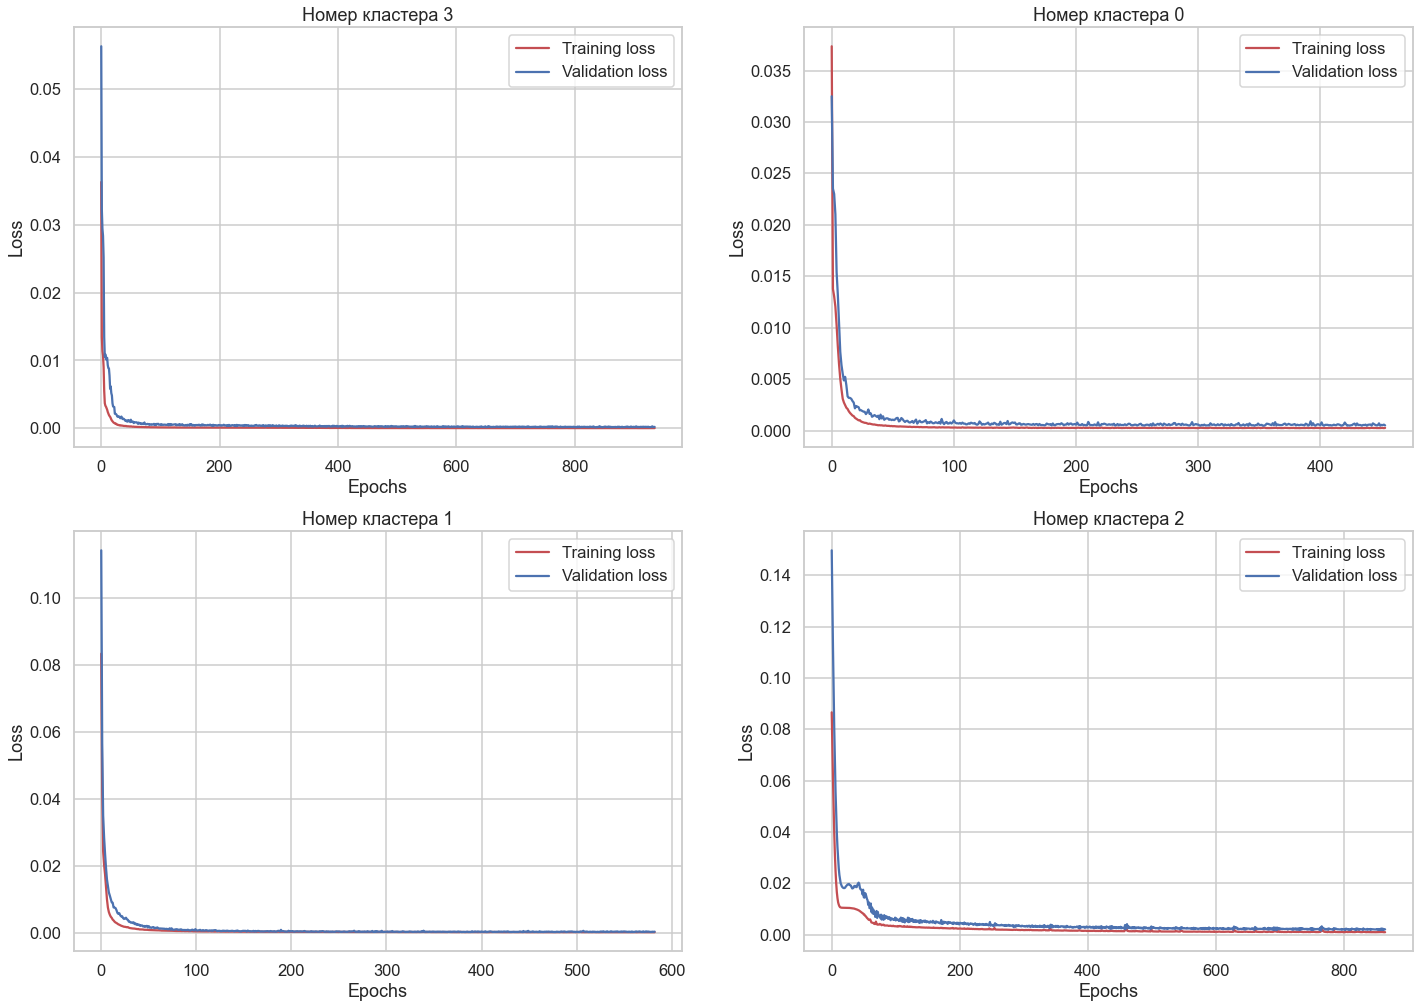

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_cl_dict_dict_norm.keys())/2))) #Размер поля

j=1
for cluster_number in df_cl_dict_dict_norm.keys():
  plt.subplot(math.ceil(len(df_cl_dict_dict_norm.keys())/2), 2, j)
  plt.plot(histories_dict_cl[cluster_number]['epoch'], histories_dict_cl[cluster_number]['loss'], 'r', label='Training loss')
  plt.plot(histories_dict_cl[cluster_number]['epoch'], histories_dict_cl[cluster_number]['val_loss'], 'b', label='Validation loss')
  plt.title(f'Номер кластера {cluster_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/loss_clusters.png'):
  plt.savefig(f'{PNG_PATH}/loss_clusters', dpi=100)
plt.show()

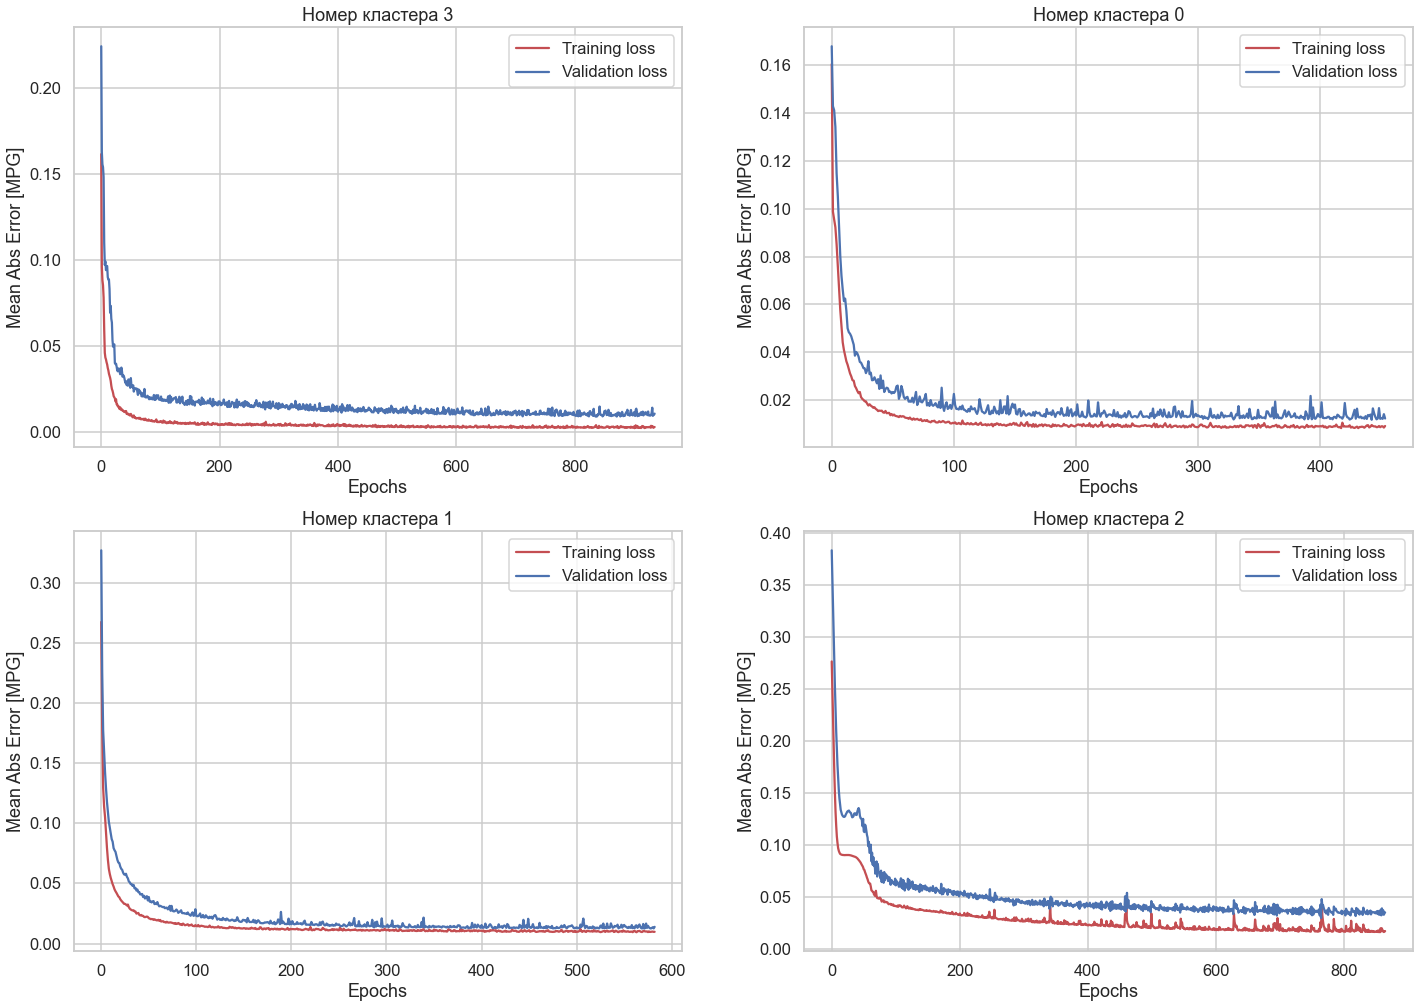

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_cl_dict_dict_norm.keys())/2))) #Размер поля

j=1
for cluster_number in df_cl_dict_dict_norm.keys():
  plt.subplot(math.ceil(len(df_cl_dict_dict_norm.keys())/2), 2, j)
  plt.plot(histories_dict_cl[cluster_number]['epoch'], histories_dict_cl[cluster_number]['mae'], 'r', label='Training loss')
  plt.plot(histories_dict_cl[cluster_number]['epoch'], histories_dict_cl[cluster_number]['val_mae'], 'b', label='Validation loss')
  plt.title(f'Номер кластера {cluster_number}') 
  plt.xlabel('Epochs')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/mae_clusters.png'):
  plt.savefig(f'{PNG_PATH}/mae_clusters', dpi=100)
plt.show()

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_cl_dict_dict_norm.keys())/2))) #Размер поля

j=1
for (result, i) in zip(model_results_save_cl, df_cl_dict_dict_norm.keys()):
  plt.subplot(math.ceil(len(df_cl_dict_dict_norm.keys())/2), 2, j)
  plt.scatter(range(y_test_clusters_full[i].shape[0]),np.array(result,dtype=float),c='r', label = 'Predition')
  plt.scatter(range(y_test_clusters_full[i].shape[0]),np.array(y_test_clusters_full[i],dtype=float),c='g', label = 'Actual')
  plt.title(f'Номер кластера {i}') 
  plt.xlabel('Epochs')
  plt.ylabel('Normed time in sec')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/prediction_actual_clusters.png'):
  plt.savefig(f'{PNG_PATH}/prediction_actual_clusters', dpi=100)
plt.show()

### Получение accuracy

#### Денормализация

In [ ]:
data_clusters_full_dn = copy.deepcopy(data_clusters_full)

target_clusters_full_dn = copy.deepcopy(target_clusters_full)

x_train_clusters_full_dn = copy.deepcopy(x_train_clusters_full)
x_test_clusters_full_dn = copy.deepcopy(x_test_clusters_full)
y_train_clusters_full_dn = copy.deepcopy(y_train_clusters_full)
y_test_clusters_full_dn = copy.deepcopy(y_test_clusters_full)
model_results_save_cl_dn = copy.deepcopy(model_results_save_cl)

In [ ]:
data_clusters_full[0][0,:,0]

array([0.46089708, 0.50378903, 0.50493907, 0.50496915, 0.51354963,
       0.5144842 , 0.51449005, 0.51454969, 0.51457105, 0.51458162])

In [ ]:
### Денормализация
for i in df_cl_dict_dict_norm.keys():
  
  for j in range(data_clusters_full_dn[i].shape[0]):
    data_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  target_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(target_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  for j in range(x_train_clusters_full_dn[i].shape[0]):
    x_train_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_clusters_full_dn[i].shape[0]):
    x_test_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  y_train_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  y_test_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  model_results_save_cl_dn[i][:,0] = max_min_scaler_denorm_for_the_column(model_results_save_cl_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')


In [ ]:
print(x_train_clusters_full_dn[1].shape)
print(x_test_clusters_full_dn[1].shape)
print(y_train_clusters_full_dn[1].shape)
print(y_test_clusters_full_dn[1].shape)
print(data_clusters_full_dn[1].shape)
print(target_clusters_full_dn[1].shape)
print(model_results_save_cl_dn[1].shape)

(1321, 10, 17)
(361, 10, 17)
(1321, 1)
(361, 1)
(1682, 10, 17)
(1682, 1)
(568, 1)


In [ ]:
for i in df_cl_dict_dict_norm.keys():
  print(i, y_test_clusters_full_dn[i].shape, model_results_save_cl_dn[i].shape, sep=' ')

3 (382, 1) (67, 1)
0 (568, 1) (382, 1)
1 (361, 1) (568, 1)
2 (67, 1) (361, 1)


In [ ]:
### Исправление
temp_3_2 = model_results_save_cl_dn[3]
temp_2_1 = model_results_save_cl_dn[2]
temp_1_0 = model_results_save_cl_dn[1]
temp_0_3 = model_results_save_cl_dn[0]

model_results_save_cl_dn[2] = temp_3_2
model_results_save_cl_dn[1] = temp_2_1
model_results_save_cl_dn[0] = temp_1_0
model_results_save_cl_dn[3] = temp_0_3

In [ ]:
for i in df_cl_dict_dict_norm.keys():
  print(i, y_test_clusters_full_dn[i].shape, model_results_save_cl_dn[i].shape, sep=' ')

3 (382, 1) (382, 1)
0 (568, 1) (568, 1)
1 (361, 1) (361, 1)
2 (67, 1) (67, 1)


#### Получение бинарного признака и расчет accuracy для отдельных кластеров

In [ ]:
transaction_before_x_test_cl = {}
actual_y_test_cl = {}
prediction_cl = {}
actual_class_cl = {}
result_class_cl = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for i in df_cl_dict_dict_norm.keys():
  transaction_before_x_test_cl[i] = x_test_clusters_full_dn[i][:,(x_test_clusters_full_dn[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test_cl[i] = y_test_clusters_full_dn[i][:,0] #реальное время след транзакции по картам
  prediction_cl[i] = model_results_save_cl_dn[i][:,0] #предсказания по картам
  actual_class_cl[i] = np.empty((actual_y_test_cl[i].shape[0]), dtype=float)
  result_class_cl[i] = np.empty((actual_y_test_cl[i].shape[0]), dtype=float)

In [ ]:
print(actual_y_test_cl[0].shape,transaction_before_x_test_cl[0].shape,prediction_cl[0].shape, sep=' ')

(568,) (568,) (568,)


In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for j in tqdm(df_cl_dict_dict_norm.keys()):
  for i in range(0, prediction_cl[j].shape[0]):
    if (actual_y_test_cl[j][i]<=((window_min*60)+transaction_before_x_test_cl[j][i])):
      actual_class_cl[j][i] = 1
    else:
      actual_class_cl[j][i] = 0
    if (prediction_cl[j][i]<=((window_min*60)+transaction_before_x_test_cl[j][i])):
      result_class_cl[j][i] = 1
    else:
      result_class_cl[j][i] = 0
  actual_class_cl[j] = actual_class_cl[j].astype('int32')
  result_class_cl[j] = result_class_cl[j].astype('int32')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 568.41it/s]


#### Получение среднего accuracy для кластеров

In [ ]:
accuracy_clusters = {}

In [ ]:
accuracy_score(actual_class_cl[3], result_class_cl[3])

In [ ]:
for i in df_cl_dict_dict_norm.keys():
  accuracy_clusters[i] = accuracy_score(actual_class_cl[i], result_class_cl[i])

In [ ]:
mean_acc = 0
for i in df_sv_card_normalized.keys():
  mean_acc = mean_acc + accuracy_cards[i]
mean_acc = mean_acc/len(accuracy_cards)
print(mean_acc)

In [ ]:
accuracy_clusters

## Сравнение результатов

In [ ]:
list(df_clusters[df_clusters['labels_PCA']==0]['CARDID_NUM'])

In [ ]:
accuracy_cards[list(df_clusters[df_clusters['labels_PCA']==0]['CARDID_NUM'])]

In [ ]:
accuracy_cards_per_cluster = {}
for i in df_cl_dict_dict_norm.keys():
  accuracy_cards_per_cluster[i] = 0
for i in df_cl_dict_dict_norm.keys():
  for j in list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']):
    accuracy_cards_per_cluster[i] = accuracy_cards_per_cluster[i] + accuracy_cards[j]
  accuracy_cards_per_cluster[i] = accuracy_cards_per_cluster[i]/len(list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']))

In [ ]:
accuracy_cards_per_cluster

In [ ]:
accuracy_clusters

### График

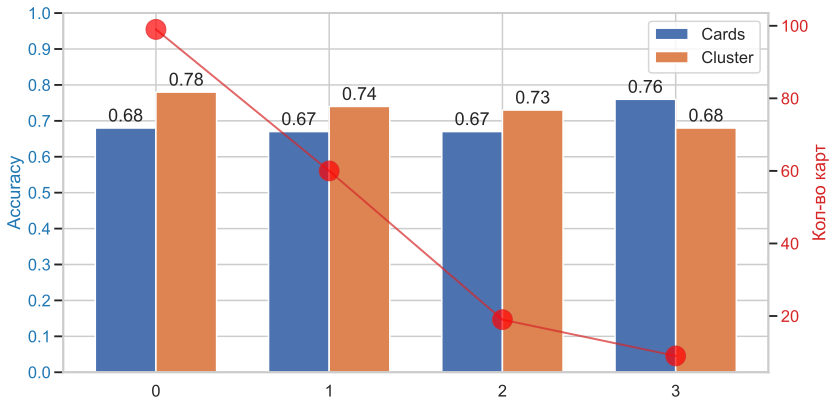

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['0', '1', '2', '3']
kards = [0.68, 0.67, 0.67, 0.76]
cluster = [0.78, 0.74, 0.73, 0.68]

num_of_transactions = np.array([[0, 99],[1,60],[2,19],[3,9]])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12,6))
rects1 = ax1.bar(x - width/2, kards, width, label='Cards')
rects2 = ax1.bar(x + width/2, cluster, width, label='Cluster')

# Add some text for labels, title and custom x-axis tick labels, etc.
color = 'tab:blue'
ax1.set_ylabel('Accuracy', color=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((0.0,1.0))
ax1.locator_params(nbins=10, axis='y')
ax1.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Кол-во карт', color=color)  # we already handled the x-label with ax1
ax2.plot(num_of_transactions[:,0], num_of_transactions[:,1], '-o', color=color, ms=20, lw=2, alpha=0.7, mfc='red')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(b=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


#fig.set_figwidth(12)    #  ширина Figure
#fig.set_figheight(6)    #  высота Figure

if not os.path.isfile(f'{PNG_PATH}/final_result_LSTM.png'):
  plt.savefig(f'{PNG_PATH}/final_result_LSTM', dpi=300)  
plt.show()